# Import Packages

In [67]:
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request
import shutil
import random
import math
import uuid
import time
import os

* `shutil.rmtree(directory_path)` - used for deleting a non-empty directory

* `uuid.uuid4()` - make secure and random id

* `urllib.request.urlretrieve(url, file_path)` - retrieve a URL into file_path

# Scraping Image

**1. `scroll_webpage`** 
   * scroll the web page if number of images to download is greater then a threshold value.

In [68]:
def scroll_webpage(driver, n_images):

    print("Scrolling the web page...")

    if n_images > 20:

        i = 0
        while i < 5:
            # for scrolling page
            driver.execute_script("window.scrollBy(0,document.body.scrollHeight)")

            try:
                # for clicking show more results button
                driver.find_element_by_xpath("/html/body/div[2]/c-wiz/div[3]/div[1]/div/div/div/div/div[5]/input").click()
            except Exception as e:
                pass

            time.sleep(5)
            i += 1

    else:
        driver.execute_script("window.scrollBy(0,document.body.scrollHeight)")

    print("Scrolling End!")

    return None

In [69]:
n_images = 60
driver_path = "readonly/chromedriver.exe"
driver = webdriver.Chrome(driver_path)
driver.get(url)

scroll_webpage(driver, n_images)

driver.close()

Scrolling the web page...
Scrolling End!


**2. `scrap_images`**

   * Opens the browser and parsing information from the web page
   
   * Helper function: `scroll_webpage`

In [70]:
def scrap_images(url, n_images, driver_path):

    driver = webdriver.Chrome(driver_path)

    print("Opening the browser...")
    driver.get(url)

    scroll_webpage(driver, n_images)
    # Parsing
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # Close the driver
    driver.close()
    print("Browser Closed!")

    img_tags = soup.find_all("img", class_="rg_i", limit=n_images)
    #imgs = soup.select('img[src^="data:image/jpeg"]')

    return img_tags

In [77]:
n_images = 60
image_name = "hotdog"
url = 'https://www.google.com/search?tbm=isch&q='+image_name
driver_path = "readonly/chromedriver.exe"

img_tags = scrap_images(url, n_images, driver_path)

print(len(img_tags))
#print(img_tags[0])

Opening the browser...
Scrolling the web page...
Scrolling End!
Browser Closed!
60


**3. `download_images`**
   * Extract links from `img` tags
   * Download images form extracted links

In [78]:
def download_images(img_tags, save_directory):

    # Check the directory
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    else:
        pass

    # Downloading iamges
    print("Start downloading.....")

    for img in img_tags:

        path1 = save_directory

        try:
            name = str(uuid.uuid4())
            path2 = name+".jpg"
            file_path = os.path.join(path1, path2)
            urllib.request.urlretrieve(img['src'], file_path)
        except:
            pass

    # Check the number of downloaded image
    n_downloded_image = len(os.listdir(save_directory))

    print("Download finished!")
    print("{} image downloaded.".format(n_downloded_image))

    return None


In [94]:
img_tags = img_tags
image_name = "hotdog"
test_save_directory = "readonly/testing/images"+"_"+image_name

download_images(img_tags, save_directory=test_save_directory)

Start downloading.....
Download finished!
55 image downloaded.


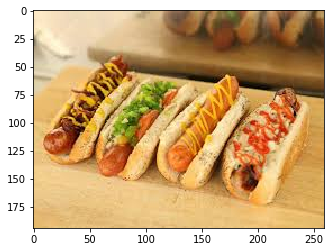

In [103]:
# Showing an image
import matplotlib.pyplot as plt
from PIL import Image
im_name = os.listdir(test_save_directory)[19]
im_path = os.path.join(test_save_directory, im_name)
im = Image.open(im_path)
plt.imshow(im)

# Creating Dataset

**1.1  `train_test_split`**
   * Splits a directory into test and train set using a given fraction 

In [104]:
def train_test_split(data_directory, split=0.8, seed=42):

    random.seed(seed)

    image_list = os.listdir(data_directory)
    random.shuffle(image_list)

    dataset_length = len(image_list)
    train_length = math.ceil(len(image_list)*split)
    test_length = len(image_list) - train_length

    train = []
    test = []

    for i in range(train_length):
        train.append(image_list[i])

    for i in range(train_length, dataset_length):
        test.append(image_list[i])

    return train, test

In [105]:
image_name = "hotdog"
test_image_directory = "readonly/testing/images"+"_"+image_name

train, test = train_test_split(data_directory=test_image_directory)

print("Training set length: {}".format(len(train)))
print("Test set length: {}".format(len(test)))

Training set length: 44
Test set length: 11


**1.2 `make_dataset`**

   * Creates train & test datasets
   
   * Helper function: `train_test_split`

In [106]:
def make_dataset(dataset_directory, image_directory, image_name, split=0.8, seed=42):

    train_path = os.path.join(dataset_directory, "train", image_name)
    test_path = os.path.join(dataset_directory, "test", image_name)

    paths = [train_path, test_path]

    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            pass

    train, test = train_test_split(image_directory, split, seed)

    for image in train:
        path = os.path.join(train_path, image)
        with open(image_directory+"/"+image, 'rb') as f:
            img = f.read()
            with open(path, "wb") as f:
                f.write(img)

    for image in test:
        path = os.path.join(test_path, image)
        with open(image_directory+"/"+image, 'rb') as f:
            img = f.read()
            with open(path, "wb") as f:
                f.write(img)

    return None

In [107]:
image_name = "hotdog"
test_image_directory = "readonly/testing/images"+"_"+image_name
test_dataset_directory = "readonly/testing/Data_Set"

make_dataset(test_dataset_directory, test_image_directory, image_name)

print(os.listdir(dataset_directory))
print("{} images found in training set!".format(len(os.listdir(test_dataset_directory+"/train/"+image_name))))
print("{} images found in test set!".format(len(os.listdir(test_dataset_directory+"/test/"+image_name))))

['test', 'train']
44 images found in training set!
11 images found in test set!


**2.1 `shuffle_csv_dataset`**
   * Shuffles rows of a csv file

In [114]:
def shuffle_csv_dataset(file_path,seed=42):

    random.seed(seed)
    
    with open(file_path,"r") as f:
        lines= f.readlines()
        header = lines[0]
        rows = lines[1:]
    
    with open(file_path,"w") as f:
        f.write(header)
        random.shuffle(rows)
        for line in rows:
            f.write(line)
    
    return rows

In [117]:
test_dataset_directory = "readonly/testing/Data_Set"
file_path = test_dataset_directory+"/test_labels.csv"

shuffle_csv_dataset(file_path)

['5bdd54b6-acd8-4dc2-aad7-4c8d832dec45.jpg,1\n',
 '947b56cf-3ffd-481e-9416-4c89b0bd7512.jpg,1\n',
 '2682d5a7-bbb1-4861-8bee-2a8106d00647.jpg,1\n',
 '504d24a1-e6e8-4e4d-bee3-a9637afac22a.jpg,1\n',
 '223e81ba-cfbc-4c7d-b703-a666137f6340.jpg,1\n',
 '26ecda58-97ca-4a64-8ee1-fc6a43f79185.jpg,1\n',
 'b2de0d08-2d5f-479d-a201-be8a4f9d1d6b.jpg,1\n',
 'c49afc51-2d7b-4f2d-8c43-25b04796cf57.jpg,1\n',
 '57dc6779-4c4b-422b-b10e-6d2bf9985e8f.jpg,1\n',
 '0896561c-90f6-4e75-8ad8-e0dc53a57b18.jpg,1\n',
 'd8623e72-af2d-4921-8cb2-175e178ed5f4.jpg,1\n']

**2.2 `train_labels_csv`**

   * Creates a csv file named `labels.csv` containig the labels of training set
   
   * Helper function: `shuffle_csv_dataset`

In [110]:
def train_labels_csv(dataset_directory, image_name, label):

    label = str(label)

    file_path = os.path.join(dataset_directory, "labels.csv")
    train_directory = os.path.join(dataset_directory,"train",image_name)

    if not os.path.exists(file_path):
        with open(file_path, "w") as f:

            header = "Image"+","+"Label"+"\n"
            f.write(header)
            
            image_list = os.listdir(train_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
                
    else:
        with open(file_path, "a") as f:
            
            image_list = os.listdir(train_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
        
            
    shuffle_csv_dataset(file_path)

    return None

In [119]:
image_name = "hotdog"
test_dataset_directory = "readonly/testing/Data_Set"

train_labels_csv(test_dataset_directory, image_name, label=1)

print("Created File Name: ", os.listdir(test_dataset_directory)[0])

Created File Name:  labels.csv


**2.3 `test_labels_csv`**

   * Creates a csv file named `test_labels.csv` containig the labels of test set.
   
   * Helper function: `shuffle_csv_dataset`

In [112]:
def test_labels_csv(dataset_directory, image_name, label):

    label = str(label)

    file_path = os.path.join(dataset_directory, "test_labels.csv")
    test_directory = os.path.join(dataset_directory,"test",image_name)

    if not os.path.exists(file_path):
        with open(file_path, "w") as f:

            header = "Image"+","+"Label"+"\n"
            f.write(header)
            
            image_list = os.listdir(test_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
                
    else:
        with open(file_path, "a") as f:
            
            image_list = os.listdir(test_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
        
            
    shuffle_csv_dataset(file_path)

    return None

In [118]:
image_name = "hotdog"
test_dataset_directory = "readonly/testing/Data_Set"

test_labels_csv(test_dataset_directory, image_name, label=1)

print("Created File Name: ", os.listdir(test_dataset_directory)[2])

Created File Name:  test_labels.csv


**3.`dataset_information`**
   * Returns usefull infos about the dataset

In [120]:
def dataset_information(dataset_directory):
    
    folders = os.listdir(dataset_directory)
    
    file_path_train = os.path.join(dataset_directory,"labels.csv")
    with open(file_path_train,"r") as f:
        lines = f.readlines()
        rows = lines[1:]
        train_len = len(rows)
        
    file_path_test = os.path.join(dataset_directory,"test_labels.csv")
    with open(file_path_test,"r") as f:
        lines = f.readlines()
        rows = lines[1:]
        test_len = len(rows)
        
    
    train_path = os.path.join(dataset_directory,"train") 
    data = {}
    for idx,img_name in enumerate(os.listdir(train_path)):
        data[idx] = img_name
        
    Information = Information = ''' ---------------------------------------
                                    Info:
                                    ---------------------------------------
                                    Data : {}
                                    Training set length : {}
                                    Test set length : {}
                                    Folders in the directory : {}
                                    ---------------------------------------'''.format( data, train_len, test_len, folders)
    
    return Information

In [121]:
test_dataset_directory = "readonly/testing/Data_Set"

info = dataset_information(test_dataset_directory)

print(info)

 ---------------------------------------
                                    Info:
                                    ---------------------------------------
                                    Data : {0: 'hotdog'}
                                    Training set length : 44
                                    Test set length : 11
                                    Folders in the directory : ['labels.csv', 'test', 'test_labels.csv', 'train']
                                    ---------------------------------------


# Main Function

* Downloads images

* If `dataset` is set to `True`,it will create the dataset

* If `del_img_dir` is set to `True`,it will delete the image directory

* If `dataset_info` is set to `True`,it will return the dataset's infos

* Prints elapsed time for parsing web page and downloading images

In [122]:
def main(dataset=False,del_img_dir=False,dataset_info=True):

    image_name = input("What do you want to download? ")
    n_images = int(input("How many images? "))
    label = int(input("Label of the image? "))
    url = 'https://www.google.com/search?tbm=isch&q='+image_name
    driver_path = "readonly/chromedriver.exe"
    image_directory = "readonly/images"+"_"+image_name
    dataset_directory = "readonly/Data_Set"
    
    tic = time.time()
    
    img_tags = scrap_images(url, n_images, driver_path)

    download_images(img_tags=img_tags, save_directory=image_directory)
    
    toc = time.time()
    
    elapsed_time = toc-tic
    
    print("Time elapsed {} seconds".format(elapsed_time))
    

    if dataset:
        make_dataset(dataset_directory, image_directory, image_name)
        train_labels_csv(dataset_directory, image_name, label)
        test_labels_csv(dataset_directory, image_name, label)
        print("Dataset Created!")
    else:
        print("Dataset is not created!")
    
    if del_img_dir:
        try:
            shutil.rmtree(image_directory)
            print("Image_directory is deleted!")
        except:
            pass
    else:
        print("Image_directory is not deleted!")
        
    
    if dataset_info:
        information = dataset_information(dataset_directory)
        print(information)
    else:
        pass

    return None

# Put it all together

In [2]:
################################ Import Packages################################################

from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request
import requests
import shutil
import random
import math
import uuid
import time
import os


##################################################################################################
######################################## Scraping Image ##########################################
##################################################################################################

def scroll_webpage(driver, n_images):

    print("Scrolling the web page...")

    if n_images > 20:

        i = 0
        while i < 5:
            # for scrolling page
            driver.execute_script(
                "window.scrollBy(0,document.body.scrollHeight)")

            try:
                # for clicking show more results button
                driver.find_element_by_xpath(
                    "/html/body/div[2]/c-wiz/div[3]/div[1]/div/div/div/div/div[5]/input").click()
            except Exception as e:
                pass

            time.sleep(5)
            i += 1

    else:
        driver.execute_script("window.scrollBy(0,document.body.scrollHeight)")

    print("Scrolling End!")

    return None

############################################################################################


def scrap_images(url, n_images, driver_path):

    driver = webdriver.Chrome(driver_path)

    print("Opening the browser...")
    driver.get(url)

    scroll_webpage(driver, n_images)
    # Parsing
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # Close the driver
    driver.close()
    print("Browser Closed!")

    img_tags = soup.find_all("img", class_="rg_i", limit=n_images)
    #imgs = soup.select('img[src^="data:image/jpeg"]')

    return img_tags

##########################################################################################################


def download_images(img_tags, save_directory):

    # Check the directory
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    else:
        pass

    # Downloading iamges
    print("Start downloading.....")

    for img in img_tags:

        path1 = save_directory

        try:
            name = str(uuid.uuid4())
            path2 = name+".jpg"
            file_path = os.path.join(path1, path2)
            urllib.request.urlretrieve(img['src'], file_path)
        except:
            pass

    # Check the number of downloaded image
    n_downloded_image = len(os.listdir(save_directory))

    print("Download finished!")
    print("{} image downloaded.".format(n_downloded_image))

    return None


####################################################################################################
###################################### Creating Dataset ############################################
####################################################################################################


def train_test_split(data_directory, split=0.8, seed=42):

    random.seed(seed)

    image_list = os.listdir(data_directory)
    random.shuffle(image_list)

    dataset_length = len(image_list)
    train_length = math.ceil(len(image_list)*split)
    test_length = len(image_list) - train_length

    train = []
    test = []

    for i in range(train_length):
        train.append(image_list[i])

    for i in range(train_length, dataset_length):
        test.append(image_list[i])

    return train, test

##################################################################################################


def make_dataset(dataset_directory, image_directory, image_name, split=0.8, seed=42):

    train_path = os.path.join(dataset_directory, "train", image_name)
    test_path = os.path.join(dataset_directory, "test", image_name)

    paths = [train_path, test_path]

    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            pass

    train, test = train_test_split(image_directory, split, seed)

    for image in train:
        path = os.path.join(train_path, image)
        with open(image_directory+"/"+image, 'rb') as f:
            img = f.read()
            with open(path, "wb") as f:
                f.write(img)

    for image in test:
        path = os.path.join(test_path, image)
        with open(image_directory+"/"+image, 'rb') as f:
            img = f.read()
            with open(path, "wb") as f:
                f.write(img)

    return None

##########################################################################################################


def shuffle_csv_dataset(file_path,seed=42):

    random.seed(seed)
    
    with open(file_path,"r") as f:
        lines= f.readlines()
        header = lines[0]
        rows = lines[1:]
    
    with open(file_path,"w") as f:
        f.write(header)
        random.shuffle(rows)
        for line in rows:
            f.write(line)
    
    return None

############################################################################################################


def train_labels_csv(dataset_directory, image_name, label):

    label = str(label)

    file_path = os.path.join(dataset_directory, "labels.csv")
    train_directory = os.path.join(dataset_directory,"train",image_name)

    if not os.path.exists(file_path):
        with open(file_path, "w") as f:

            header = "Image"+","+"Label"+"\n"
            f.write(header)
            
            image_list = os.listdir(train_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
                
    else:
        with open(file_path, "a") as f:
            
            image_list = os.listdir(train_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
        
            
    shuffle_csv_dataset(file_path)

    return None

############################################################################################################


def test_labels_csv(dataset_directory, image_name, label):

    label = str(label)

    file_path = os.path.join(dataset_directory, "test_labels.csv")
    test_directory = os.path.join(dataset_directory,"test",image_name)

    if not os.path.exists(file_path):
        with open(file_path, "w") as f:

            header = "Image"+","+"Label"+"\n"
            f.write(header)
            
            image_list = os.listdir(test_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
                
    else:
        with open(file_path, "a") as f:
            
            image_list = os.listdir(test_directory)
            
            for img in image_list:
                single_row = img+","+label+"\n"
                f.write(single_row)
        
            
    shuffle_csv_dataset(file_path)

    return None

############################################################################################################


def dataset_information(dataset_directory):
    
    folders = os.listdir(dataset_directory)
    
    file_path_train = os.path.join(dataset_directory,"labels.csv")
    with open(file_path_train,"r") as f:
        lines = f.readlines()
        rows = lines[1:]
        train_len = len(rows)
        
    file_path_test = os.path.join(dataset_directory,"test_labels.csv")
    with open(file_path_test,"r") as f:
        lines = f.readlines()
        rows = lines[1:]
        test_len = len(rows)
        
    
    train_path = os.path.join(dataset_directory,"train") 
    data = {}
    for idx,img_name in enumerate(os.listdir(train_path)):
        data[idx] = img_name
        
    Information = Information = ''' ---------------------------------------
                                    Info:
                                    ---------------------------------------
                                    Data : {}
                                    Training set length : {}
                                    Test set length : {}
                                    Folders in the directory : {}
                                    ---------------------------------------'''.format( data, train_len, test_len, folders)
    
    return Information

##########################################################################################################
######################################## Main Function ###################################################
##########################################################################################################


def main(dataset=False,del_img_dir=False,dataset_info=True):

    image_name = input("What do you want to download? ")
    n_images = int(input("How many images? "))
    label = int(input("Label of the image? "))
    url = 'https://www.google.com/search?tbm=isch&q='+image_name
    driver_path = "readonly/chromedriver.exe"
    image_directory = "readonly/images"+"_"+image_name
    dataset_directory = "readonly/Data_Set"
    
    tic = time.time()
    
    img_tags = scrap_images(url, n_images, driver_path)

    download_images(img_tags=img_tags, save_directory=image_directory)
    
    toc = time.time()
    
    elapsed_time = toc-tic
    
    print("Time elapsed {} seconds".format(elapsed_time))
    

    if dataset:
        make_dataset(dataset_directory, image_directory, image_name)
        train_labels_csv(dataset_directory, image_name, label)
        test_labels_csv(dataset_directory, image_name, label)
        print("Dataset Created!")
    else:
        print("Dataset is not created!")
    
    if del_img_dir:
        try:
            shutil.rmtree(image_directory)
            print("Image_directory is deleted!")
        except:
            pass
    else:
        print("Image_directory is not deleted!")
        
    
    if dataset_info:
        information = dataset_information(dataset_directory)
        print(information)
    else:
        pass

    return None

#############################################################################################################
#############################################################################################################
#############################################################################################################


if __name__ == '__main__':

    main(dataset=True)

What do you want to download? cat
How many images? 60
Label of the image? 1
Opening the browser...
Scrolling the web page...
Scrolling End!
Browser Closed!
Start downloading.....
Download finished!
55 image downloaded.
Time elapsed 42.68992042541504 seconds
Dataset Created!
Image_directory is not deleted!
 ---------------------------------------
                                    Info:
                                    ---------------------------------------
                                    Data : {0: 'car', 1: 'cat'}
                                    Training set length : 82
                                    Test set length : 20
                                    Folders in the directory : ['labels.csv', 'test', 'test_labels.csv', 'train']
                                    ---------------------------------------
